/home/sayhello/miniconda3/envs/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-29 19:01:20.903103: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 19:01:20.940984: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 19:01:20.941579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 19:01:21.656015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


dict_keys(['image', 'anomaly_mask', 'augmented_image', 'has_anomaly', 'idx'])
has_ano shape: torch.Size([16, 1])
torch.Size([16, 3, 256, 256])


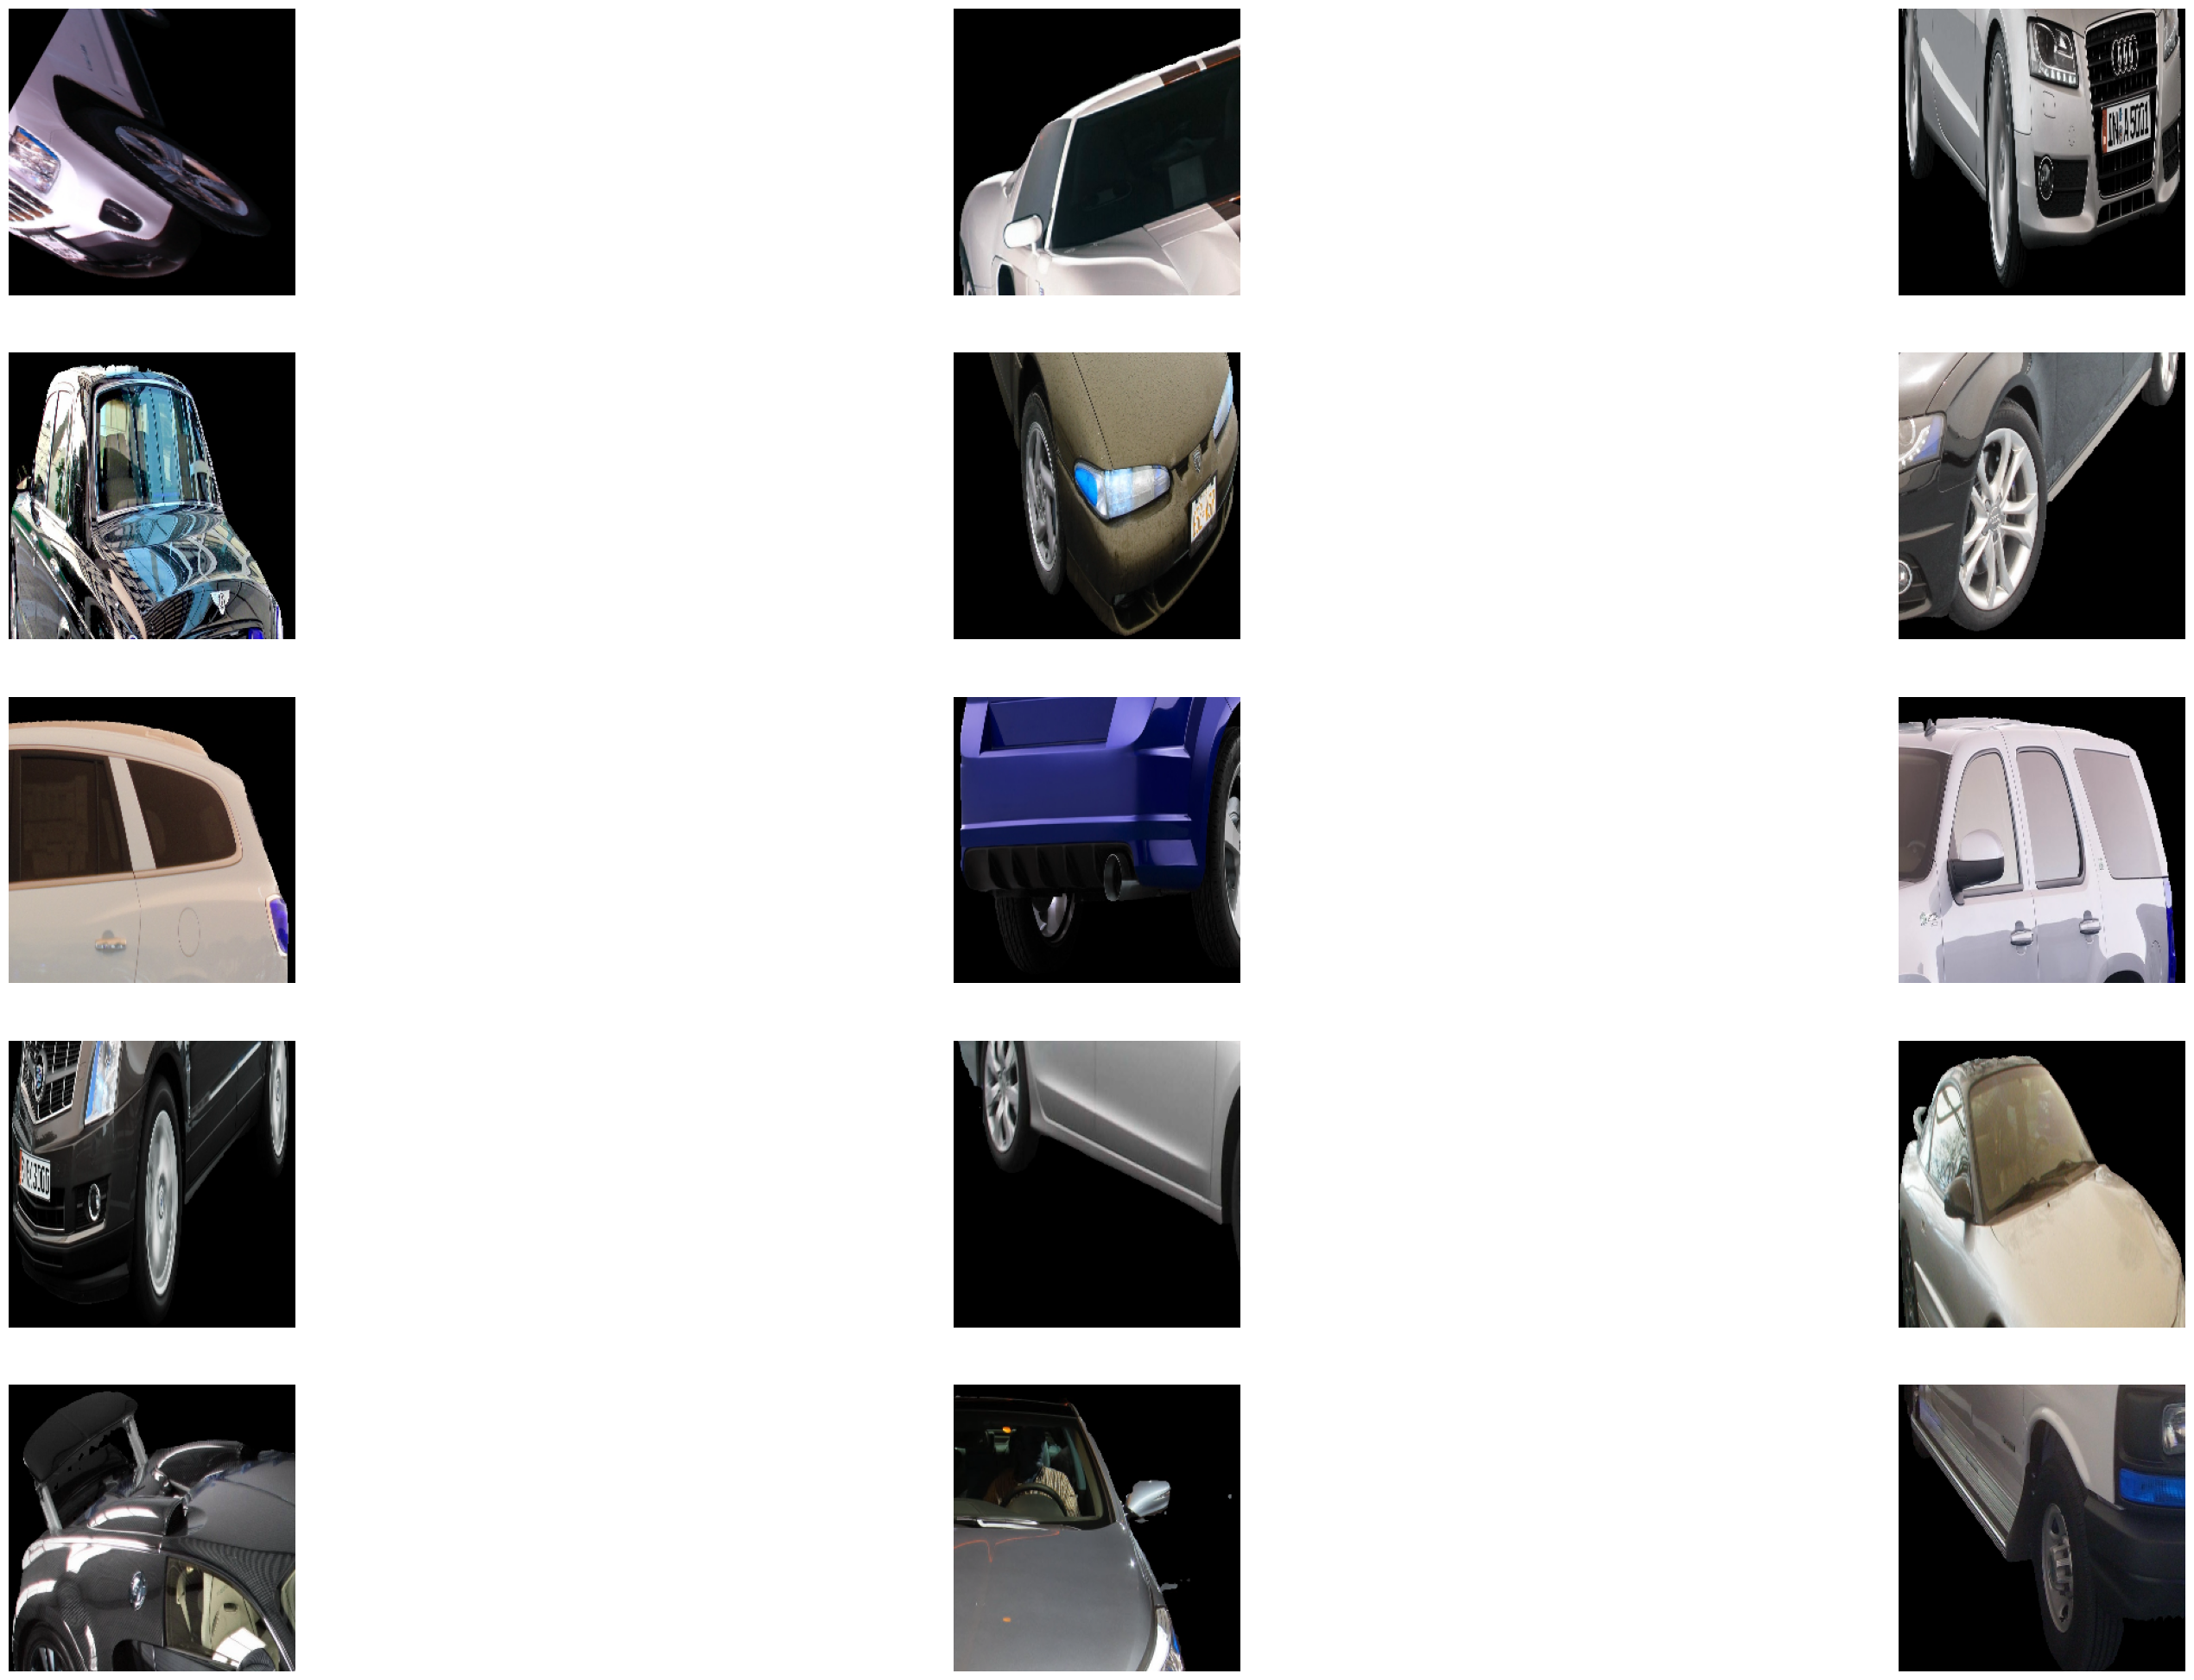

In [1]:
from lightning import Trainer
import torch
from data_loader import MVTecDRAEMTestDataset, MVTecDRAEMTrainDataset
from torch.utils.data import DataLoader
from torch import optim
from tensorboard_visualizer import TensorboardVisualizer
from model_unet import ReconstructiveSubNetwork, DiscriminativeSubNetwork
from loss import FocalLoss, SSIM
import os
from models.Draem import DraemModel
import matplotlib.pyplot as plt
import numpy as np

def train_on_device(obj_names, args):


    for obj_name in obj_names:
        run_name = 'DRAEM_test_'+str(args.lr)+'_'+str(args.epochs)+'_bs'+str(args.bs)+"_"+obj_name+'_'



        dataset = MVTecDRAEMTrainDataset(args.data_path + obj_name + "/train/good/", args.anomaly_source_path, resize_shape=[256, 256], ignore_black_region=True, use_multi_scale=True, bias_perlin=True, low_to_high=False, bias_perlin_max=6, train_with_no_aug=True)

        dataloader = DataLoader(dataset, batch_size=args.bs,
                                shuffle=True, num_workers=1)
        

                # Get a batch of data
        batch_idx, batch_data = next(enumerate(dataloader))
        print(batch_data.keys())   
        has_ano = batch_data['has_anomaly']
        images = batch_data['augmented_image']
        # Extract images from the batch
        print('has_ano shape:',has_ano.shape)
        print(images.shape)
        #has_ano = has_ano.bool().squeeze(dim=1)

        #images = images[has_ano]
        batch_idx, batch_data = next(enumerate(dataloader))

        # Extract images from the batch
        
      

     
        # Plot the images
        num_of_imgs_3rd = int(len(images)/3)
        fig, axes = plt.subplots(num_of_imgs_3rd, 3, figsize=(40, 25))

        
        for i in range(num_of_imgs_3rd):
            for j in range(3):
                idx = i * 3 + j
                axes[i, j].imshow(np.transpose(images[idx], (1, 2, 0)))  # Assuming images are in (channels, height, width) format
                axes[i, j].axis('off')
        plt.savefig('draem_default.png')
        plt.show()
        '''
       
        for batch_idx, batch_data in enumerate(dataloader):
            images = batch_data['image']
            augmented_images = batch_data['augmented_image']
            anomaly_masks = batch_data['anomaly_mask']
            has_anomaly = batch_data['has_anomaly']

          
            print(f'Batch Index: {batch_idx}, Images shape: {images.shape}, Augmented Images shape: {augmented_images.shape}, Anomaly Masks shape: {anomaly_masks.shape}, Has Anomaly: {has_anomaly}')


        '''
        #dataset = MVTecDRAEMTestDataset('./datasets/mvtec/' + obj_name + "/test/", resize_shape=[256, 256])
        #dataloader = DataLoader(dataset, batch_size=10,
        #                        shuffle=False, num_workers=0)

        #trainer.test(model, dataloader)


import argparse
###########RUNNING ON SPLIT IMAGES
# Define your arguments and their default values
default_args = {
    'obj_id': 0,
    'bs': 16,
    'lr': 0.0001,
    'epochs': 8,
    'gpu_id': 0,
    'data_path': './datasets/mvtec/',
    'anomaly_source_path': './datasets/dtd/images/',
    'checkpoint_path': './checkpoints/',
    'log_path': './logs/',
    'visualize': False,
}

# Create an ArgumentParser to get the argument names
parser = argparse.ArgumentParser()
for arg_name, arg_value in default_args.items():
    arg_type = type(arg_value)
    parser.add_argument(f'--{arg_name}', action='store', type=arg_type, default=arg_value)

# Parse the arguments using the default values
args = parser.parse_args([])


obj_batch = [   ['cars'],
                ['capsule'],
                 ['bottle'],
                 ['carpet'],
                 ['leather'],
                 ['pill'],
                 ['transistor'],
                 ['tile'],
                 ['cable'],
                 ['zipper'],
                 ['toothbrush'],
                 ['metal_nut'],
                 ['hazelnut'],
                 ['screw'],
                 ['grid'],
                 ['wood']
                 ]

if int(args.obj_id) == -1:
        obj_list = ['cars',
                    'capsule',
                     'bottle',
                     'carpet',
                     'leather',
                     'pill',
                     'transistor',
                     'tile',
                     'cable',
                     'zipper',
                     'toothbrush',
                     'metal_nut',
                     'hazelnut',
                     'screw',
                     'grid',
                     'wood'
                     ]
        picked_classes = obj_list
else:
        picked_classes = obj_batch[int(args.obj_id)]

with torch.cuda.device(args.gpu_id):
        train_on_device(picked_classes, args)